In [1]:
import sys, os
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

CURRENT_PATH = os.path.dirname(os.getcwd())
sys.path.insert(0, CURRENT_PATH)
sys.path.insert(0, CURRENT_PATH + '\\Modules')

In [2]:
norm_pdf = lambda x: stats.norm.pdf(x)
norm_cdf = lambda x: stats.norm.cdf(x)
norm_icdf = lambda x: stats.norm.ppf(x)

In [3]:
from scipy.integrate import quad

def integrand(x, mu, nu, r, pd):
    a = (mu + r * nu * x)
    b = nu**2 * (1 - r**2)
    return norm_cdf(a / np.sqrt(1 + b)) * norm_pdf(x) / pd

nu = 1.0
mu = 0

pds = np.exp(np.linspace(np.log(1e-4), np.log(0.2), 100))
rhos = [-0.1, -0.3, -0.45, -0.6, -0.75, -0.9]
ldg_rhos = {}

for rho in rhos:
    final_ldg = []

    for pd in pds:
        L = norm_icdf(pd)
        I = quad(integrand, -np.inf, L, args=(mu, nu, rho, pd))

        final_ldg.append(1 - I[0])
    ldg_rhos[rho] = np.array(final_ldg)

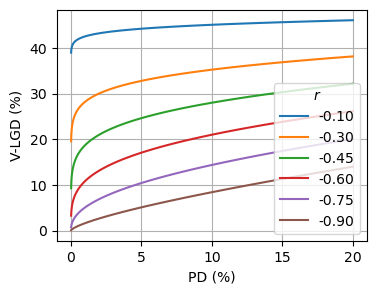

In [4]:
plt.figure(figsize=(4, 3))

for rho in ldg_rhos:
    final_ldg = ldg_rhos[rho]
    plt.plot(100 * pds, 100 * final_ldg, label='{:.2f}'.format(rho))

plt.legend(title=r'$r$')
plt.xlabel('PD (%)')
plt.ylabel('V-LGD (%)');
plt.grid()

# plt.savefig(CURRENT_PATH + '\\Output\\merton_vasicek_lgd_rho', format='png', dpi=300, bbox_inches = "tight")

In [5]:
nu = 1.0
rho = -0.6

ldg_mus = {}

mus = [-1, -0.5, 0, 0.5, 1.0]

for mu in mus:
    final_ldg = []

    for pd in pds:
        L = norm_icdf(pd)
        I = quad(integrand, -np.inf, L, args=(mu, nu, rho, pd))

        final_ldg.append(1 - I[0])
    ldg_mus[mu] = np.array(final_ldg)

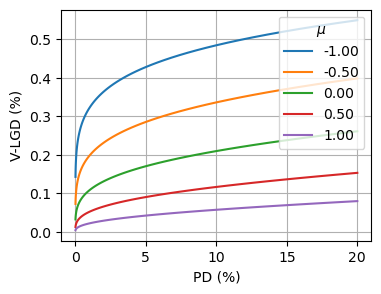

In [6]:
plt.figure(figsize=(4, 3))

for mu in ldg_mus:
    final_ldg = ldg_mus[mu]
    plt.plot(100*pds, final_ldg, label='{:.2f}'.format(mu))

plt.legend(title=r'$\mu$')
plt.xlabel('PD (%)')
plt.ylabel('V-LGD (%)');
plt.grid()

# plt.savefig(CURRENT_PATH + '\\Output\\merton_vasicek_lgd_lgd0', format='png', dpi=300, bbox_inches = "tight")

In [7]:
nu = 1.0
rho = -0.6
mu = 0.0
pd = 0.05

ldg_nus = {}

nus = [0, 0.25, 0.5, 1.0, 2.0]

for nu in nus:
    final_ldg = []

    for pd in pds:
        L = norm_icdf(pd)
        I = quad(integrand, -np.inf, L, args=(mu, nu, rho, pd))

        final_ldg.append(1 - I[0])
    ldg_nus[nu] = np.array(final_ldg)

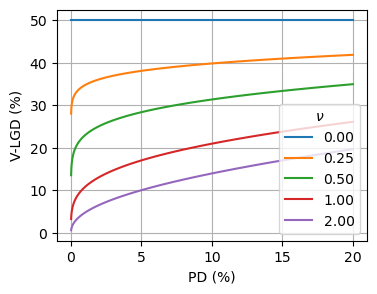

In [8]:
plt.figure(figsize=(4, 3))

for nu in ldg_nus:
    final_ldg = ldg_nus[nu]
    plt.plot(pds * 100, final_ldg * 100, label='{:.2f}'.format(nu))

plt.legend(title=r'$\nu$')
plt.xlabel('PD (%)')
plt.ylabel('V-LGD (%)');
plt.grid()

# plt.savefig(CURRENT_PATH + '\\Output\\merton_vasicek_lgd_nu', format='png', dpi=300, bbox_inches = "tight")

##### Setting parameters (several methods)

In [9]:
%%time

rho = -0.6
nu = 1.0
pd_ttc = 0.05
elgd = 0.25

def mu_estimator(pd, rho, nu):
    L = norm_icdf(pd)

    mus = np.linspace(-5, 5, 10)

    mu = np.inf
    diff = np.inf

    while diff > 1e-5:
      final_ldg = [np.inf]

      for mu in mus:
          I = quad(integrand, -np.inf, L, args=(mu, nu, rho, pd))

          final_ldg.append((1 - I[0] - elgd)**2)

          if final_ldg[-1] > final_ldg[-2]:
              final_ldg.pop(0)
              mus = np.linspace(mus[np.argmin(final_ldg) - 1], mus[np.argmin(final_ldg) + 1], 10)
              diff = np.abs(mus[-1] - mus[0])
              break

    return mus[np.argmin(final_ldg)]

mu_hat = mu_estimator(pd_ttc, rho, nu)

L = norm_icdf(pd_ttc)
Xs = np.random.randn(int(1e6))
Xs = Xs[Xs <= L]
print(mu_hat, Xs.shape)

quad(integrand, -np.inf, L, args=(mu_hat, nu, rho, pd_ttc))[0] / (1 - elgd)

-0.36020371127806566 (49930,)
CPU times: total: 375 ms
Wall time: 1.52 s


1.0000000139094396

In [10]:
%%time

def mu_estimator(pd, rho, nu):
    L = norm_icdf(pd)

    Xs = np.random.randn(int(1e6))
    Xs = Xs[Xs <= L]

    return np.mean(norm_icdf(1 - elgd) * np.sqrt(1 + nu**2 * (1 - rho**2)) - rho * nu * Xs)

mu_hat = mu_estimator(pd_ttc, rho, nu)

print(mu_hat)

quad(integrand, -np.inf, L, args=(mu_hat, nu, rho, pd_ttc))[0] / (1 - elgd)

-0.37485100428719986
CPU times: total: 15.6 ms
Wall time: 55.2 ms


0.9951990798770197

In [11]:
%%time

def mu_estimator(pd, rho, nu):
    L = norm_icdf(pd)

    objective = lambda mu: (1 - quad(integrand, -np.inf, L, args=(mu, nu, rho, pd_ttc))[0] - elgd)**2

    solution = minimize(fun=objective, x0=0.0, method='BFGS', tol=0.0, options={'maxiter': 10000})

    return solution.x[0]

mu_hat = mu_estimator(pd_ttc, rho, nu)

print(mu_hat)

# np.mean(norm_cdf((mu_hat + rho * nu * Xs) / np.sqrt(1 + nu**2 * (1 - rho**2)))) / (1 - elgd)
quad(integrand, -np.inf, L, args=(mu_hat, nu, rho, pd_ttc))[0] / (1 - elgd)

-0.3602037613256201
CPU times: total: 672 ms
Wall time: 1.62 s


0.9999999975672141

In [12]:
%%time

def mu_estimator(elgd, pd, rho, nu):
    L = norm_icdf(pd)

    Xs = np.random.randn(int(1e6))
    Xs = Xs[Xs <= L]

    objective = lambda mu: (1 - np.mean(norm_cdf((mu + rho * nu * Xs) / np.sqrt(1 + nu**2 * (1 - rho**2)))) - elgd)**2
    solution = minimize(fun=objective, x0=0.0, method='BFGS', tol=0.0, options={'maxiter': 10000})

    return solution.x[0]

mu_hat = mu_estimator(elgd, pd_ttc, rho, nu)

print(mu_hat)

# np.mean(norm_cdf((mu_hat + rho * nu * Xs) / np.sqrt(1 + nu**2 * (1 - rho**2)))) / (1 - elgd)
quad(integrand, -np.inf, L, args=(mu_hat, nu, rho, pd_ttc))[0] / (1 - elgd)

-0.36126748273026066
CPU times: total: 31.2 ms
Wall time: 173 ms


0.9996525607015795

In [13]:
ldg_nus = {}

for nu in nus:
    final_ldg = []
    mu_hat = mu_estimator(elgd, pd_ttc, rho, nu)

    for pd in pds:

        I = quad(integrand, -np.inf, norm_icdf(pd), args=(mu_hat, nu, rho, pd))

        final_ldg.append(1 - I[0])

    ldg_nus[nu] = np.array(final_ldg)

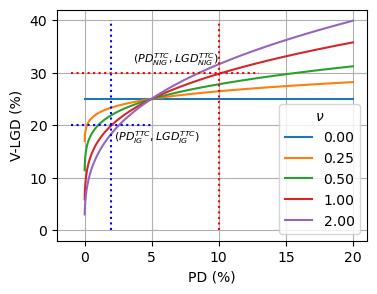

In [14]:
plt.figure(figsize=(4, 3))

for nu in ldg_nus:
    final_ldg = ldg_nus[nu]
    plt.plot(pds * 100, final_ldg * 100, label='{:.2f}'.format(nu))

plt.vlines(x=2, ymin=0, ymax=40, linestyle='dotted', colors='Blue')
plt.hlines(y=20, xmin=-1.0, xmax=5, linestyle='dotted', colors='Blue')
plt.vlines(x=10, ymin=0, ymax=40, linestyle='dotted', colors='Red')
plt.hlines(y=30, xmin=-1.0, xmax=13, linestyle='dotted', colors='Red')

plt.text(x=2.2, y=17, s=r'$(PD^{TTC}_{IG}, LGD^{TTC}_{IG})$', fontsize=8)
plt.text(x=3.6, y=32, s=r'$(PD^{TTC}_{NIG}, LGD^{TTC}_{NIG})$', fontsize=8)

plt.legend(title=r'$\nu$')
plt.xlabel('PD (%)')
plt.ylabel('V-LGD (%)');
plt.grid()

# plt.savefig(CURRENT_PATH + '\\Output\\merton_vasicek_lgd_nu_muhat', format='png', dpi=300, bbox_inches = "tight")

### Surface plot

In [15]:
x_ = np.linspace(1e-3, 0.1, 30)
shocks = np.linspace(0.0, 0.1, 20)

nu = 1.0
mu_hat = mu_estimator(elgd, pd_ttc, rho, nu)

lgd_shocks = np.zeros((len(x_), len(shocks)))

for i, pd in enumerate(x_):
    for j, s in enumerate(shocks):
        I = quad(integrand, -np.inf, norm_icdf(pd + s), args=(mu_hat, nu, rho, pd + s))

        lgd_shocks[i, j] = 1 - I[0]

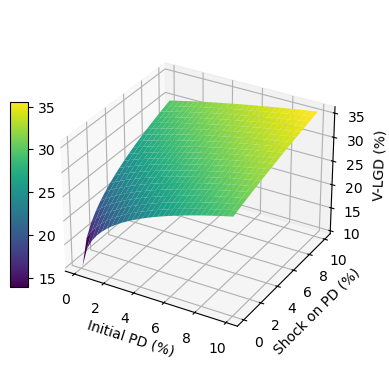

In [16]:
fig = plt.figure()
x = x_
y = shocks
X, Y = np.meshgrid(x, y)
Z = lgd_shocks.T

ax = plt.axes(projection='3d')
surf = ax.plot_surface(100*X, 100*Y, 100*Z, rstride=1, cstride=1, cmap='viridis')

ax.set_xlabel('Initial PD (%)', rotation=0)
ax.set_ylabel('Shock on PD (%)', rotation=0)
ax.set_zlabel('V-LGD (%)', rotation=0)

axins1 = inset_axes(
    ax,
    width="5%",  # width: 50% of parent_bbox width
    height="50%",  # height: 5%
    loc="center left",
    borderpad=0
)

axins1.xaxis.set_ticks_position("default")
fig.colorbar(surf, cax=axins1)

ax.zaxis.set_major_locator(plt.MaxNLocator(6))

ax.set_box_aspect(aspect=None, zoom=0.83)
# ax.set_aspect('auto')

# plt.savefig(CURRENT_PATH + '\\Output\\surface_vasicek_lgd.png', format='png', dpi=300, bbox_inches = "tight")

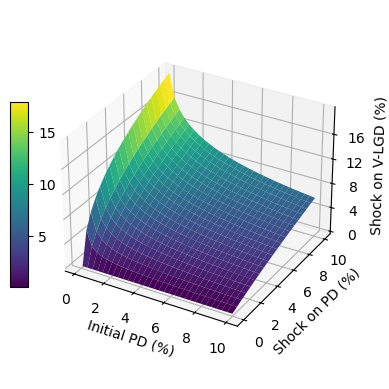

In [17]:
# Axes3D import has side effects, it enables using projection='3d' in add_subplot

fig = plt.figure()
x = x_
y = shocks
X, Y = np.meshgrid(x, y)
Z = lgd_shocks.T
Z = Z - Z[0]

ax = plt.axes(projection='3d')
surf = ax.plot_surface(100*X, 100*Y, 100*Z, rstride=1, cstride=1, cmap='viridis')

ax.set_xlabel('Initial PD (%)', rotation=0)
ax.set_ylabel('Shock on PD (%)', rotation=0)
ax.set_zlabel('Shock on V-LGD (%)', rotation=0)

axins1 = inset_axes(
    ax,
    width="5%",  # width: 50% of parent_bbox width
    height="50%",  # height: 5%
    loc="center left",
    borderpad=0
)

axins1.xaxis.set_ticks_position("default")
fig.colorbar(surf, cax=axins1)

ax.zaxis.set_major_locator(plt.MaxNLocator(6))

ax.set_box_aspect(aspect=None, zoom=0.83)
# ax.set_aspect('auto')

# plt.savefig(CURRENT_PATH + '\\Output\\surface_vasicek_lgd_shock.png', format='png', dpi=300, bbox_inches = "tight")